#**Text Analysis of News Articles**

*In this notebook, my main objective was to attempt text analysis and stylometric analysis of news articles. Before jumping to that, I performed data exploration, cleaning and preprocessing.*

*After text analysis, I tried to develop a binary text classification model using ML algorithms in seperate notebook.*





*Download dataset from:* https://www.kaggle.com/competitions/fake-news/data/?select=train.csv

# Importing Requirements

---



In [ ]:
## Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 16.5 MB/s eta 0:00:00


In [ ]:
## Import requirements

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,8)
import warnings
warnings.filterwarnings('ignore')


import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import re
import contractions
from wordcloud import WordCloud
import string
from collections import Counter
'''
from nltk.stem.porter import PorterStemmer

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report
'''

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


'\nfrom nltk.stem.porter import PorterStemmer\n\nfrom tensorflow.keras.preprocessing.text import one_hot\nfrom tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout\nfrom tensorflow.keras.preprocessing.sequence import pad_sequences\nfrom tensorflow.keras.models import Sequential\n\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, classification_report\n'

# Data Exploration
---

In [ ]:
## Import dataset
train_df = pd.read_csv('/content/drive/MyDrive/FakeNewsDetection/Data/train.csv')

print(f'Shape of training data: {train_df.shape}')

In [ ]:
## Training data information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
## Looking at training data
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


**NOTE:**

**Label 0 : Genuine News**

**Label 1 : Fake News**

In [ ]:
## Null values in training data

train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
## Remove all null values
train_df = train_df.dropna()

## Modified shape
train_df.shape

(18285, 5)

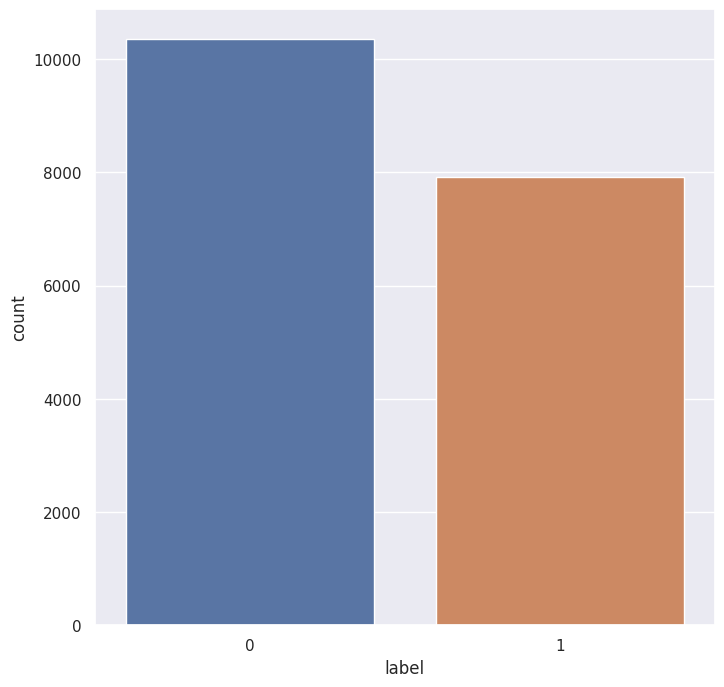

In [ ]:
## Distribution of labels in training

sns.set_theme(style= 'darkgrid')
sns.countplot(x= 'label', data= train_df)
plt.show()

**Ratio of genuine to reliable is approximately 5:4.**

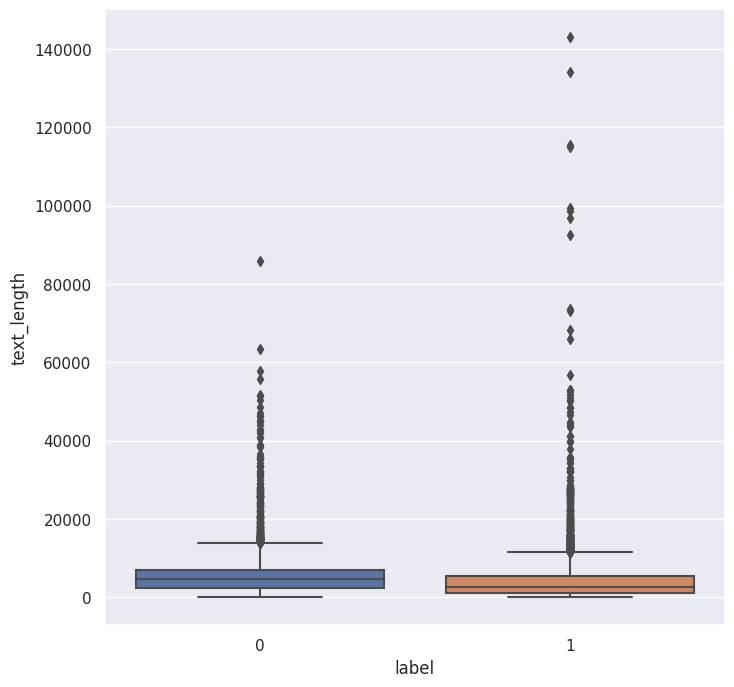

In [ ]:
## Looking at the relationship between the label and length of articles

train_df['text_length'] = train_df['text'].apply(lambda x: len(x))
sns.boxplot(x= 'label', y= 'text_length', data= train_df)
plt.show()

**It could be seen that median text length is lower for fake news articles as compared to genuine articles. For both, minimum text length starts from 0, which is concerning. Let's dig into the issue by using descrptive statistics.....**

In [ ]:
## Descriptive summary of dataset

train_df.describe()

,id,label,text_length
count,18285.000000,18285.000000,18285.000000
mean,10409.807383,0.433361,4800.181843
std,5998.216236,0.495553,5225.865069
min,0.000000,0.000000,1.000000
25%,5217.000000,0.000000,1834.000000
50%,10422.000000,0.000000,3694.000000
75%,15603.000000,1.000000,6535.000000
max,20799.000000,1.000000,142961.000000


**Text length is actually starting from 1. Let's look at these articles:**

In [ ]:
## Articles having length 1:

train_df[train_df['text_length'] == 1]

,id,title,author,text,label,text_length
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,,1,1
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1,1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1,1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1,1
592,592,Is your promising internet career over now Vin...,newsbiscuit editorial team,,1,1
...,...,...,...,...,...,...
19857,19857,"A Fifth Clinton Presidency? Hill, No!",Michelle Malkin,,1,1
19929,19929,98% of public now ‘really looking forward’ to ...,NewsBiscuit,,1,1
20242,20242,Radio Derb Transcript For October 21 Up: The M...,John Derbyshire,,1,1
20264,20264,Pro-sovereignty Legislators Demand That Admini...,Brenda Walker,,1,1


**These are blank articles having single space ' ', recording 73 rows. They can be converted to empty strings by stripping.**


**So, I'll start all over again and fill null values as single spaces. Then, I'll strip them and finally, remove these zero length texts.**

In [ ]:
## Import train dataset
#-------------------------------------------------------------------------------
train_df = pd.read_csv('/content/drive/MyDrive/FakeNewsDetection/Data/train.csv')


## Fill nulls by ' '
#-------------------------------------------------------------------------------
train_df = train_df.fillna(' ')


## Strip leading and trailing spaces from text
#-------------------------------------------------------------------------------
train_df['text'] = train_df['text'].str.strip()
train_df['text_length'] = train_df['text'].apply(lambda x: len(x))


## Removing zero length texts
#-------------------------------------------------------------------------------
train_df = train_df[train_df['text_length'] > 0]


print(f'New shape: {train_df.shape}')
print(f'\n\nNull valurs:\n{train_df.isna().sum()}')
print(f'\n\nNumber of zero length texts:\n{len(train_df[train_df.text_length == 0])}')

New shape: (20684, 6)


Null valurs:
id             0
title          0
author         0
text           0
label          0
text_length    0
dtype: int64


Number of zero length texts:
0


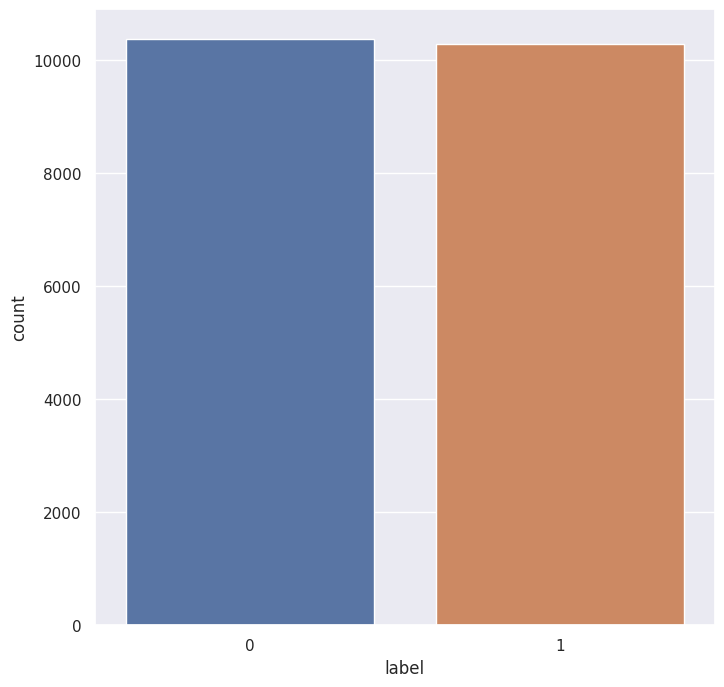

In [ ]:
## Distribution of labels in training

sns.set_theme(style= 'darkgrid')
sns.countplot(x= 'label', data= train_df)
plt.show()

**Ratio of genuine to reliable almost became 1:1, which shows that dataset is completely balanced.**

In [ ]:
## Duplicate records

train_df[train_df.duplicated()]

,id,title,author,text,label,text_length


**No duplicate records found**

In [ ]:
## Saving original training dataset
org_train_df = train_df.copy()

#Text Preprocessing
---

In [ ]:
## Looking at overlapping authors who have contributed both genuine & fake articles.

genuine_authors = set(list(train_df[train_df['label'] == 0]['author']))
fake_authors =  set(list(train_df[train_df['label'] == 1]['author']))
overlap = genuine_authors.intersection(fake_authors)

print(f'No. of authors contributing genuine news: {len(genuine_authors)}')
print(f'\nNo. of authors contributing fake news: {len(fake_authors)}')
print(f'\nNo. of overlapping authors: {len(overlap)}')

No. of authors contributing genuine news: 2226

No. of authors contributing fake news: 1976

No. of overlapping authors: 6


**Since overapping authors are relatively negligible, it indicates author can be an important feature in predicting the fake news**

Text Cleaning Steps:
1. Remove special characters
2. Expand contractions
3. Convert to lower-case
4. Word Tokenize
5. Remove Stopwords

In [ ]:
features = list(train_df.describe(include= ['O']).columns) # Features containing textual data
stop_words = stopwords.words('english') # Default English stop words in nltk library


## Function for text cleaning
#-------------------------------------------------------------------------------
def clean_text(text):

  '''Remove special characters and expand contractions'''
  cleaned = re.sub(r'[^a-zA-Z\d\s\']+', '', text)

  words_expanded = []
  for word in cleaned.split():
    try:
      words_expanded.append(contractions.fix(word).lower())
    except:
      print(text)

  cleaned = " ".join(words_expanded)
  return cleaned


## Apply function for text cleaning
#-------------------------------------------------------------------------------
for feat in features:
  train_df[feat] = train_df[feat].apply(clean_text)

In [ ]:
## Function for tokenizing
#-------------------------------------------------------------------------------
def tokenize(x):
  return word_tokenize(x)


## Apply function for tokenizing
#-------------------------------------------------------------------------------
for feat in features:
  train_df[feat] = train_df[feat].apply(tokenize)

In [ ]:
## Function for removal of stop words
#-------------------------------------------------------------------------------
def remove_stopwords(x):
  processed = [word for word in x if word not in stop_words]
  return processed


## Apply function for stop words removal
#-------------------------------------------------------------------------------
for feat in features:
  train_df[feat] = train_df[feat].apply(remove_stopwords)

# Text Analysis
---

**Word Cloud:**

Looking at the frequent words per label using wordcloud for training dataset.

In [ ]:
## Joining word sequences of 'text' to a single string
#-------------------------------------------------------------------------------
train_df['joined_text'] = train_df['text'].apply(lambda x: " ".join(x))

## Combine all texts in respective labels
#-------------------------------------------------------------------------------
comb_gen_texts = " ".join(train_df[train_df['label'] == 0]['joined_text'])
comb_fake_texts = " ".join(train_df[train_df['label'] == 1]['joined_text'])

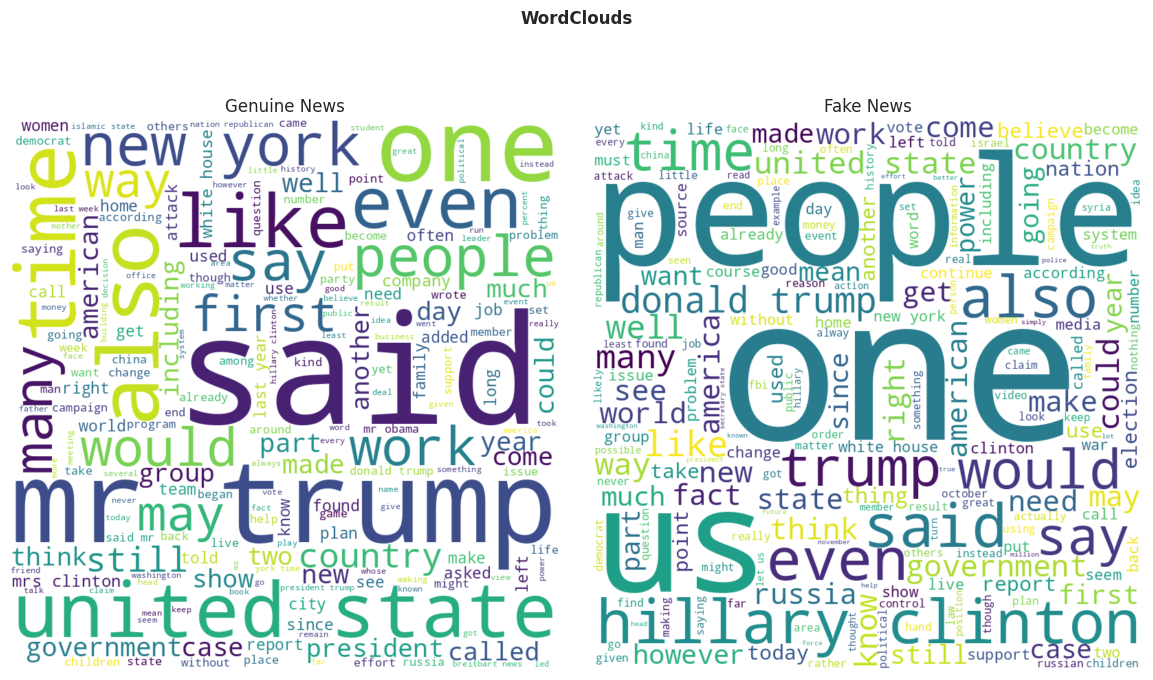

In [ ]:
## WordClouds per label
#-------------------------------------------------------------------------------

wordcloud_genuine = WordCloud(width= 800, height= 800, background_color= 'white',
          stopwords= stop_words, min_font_size= 8).generate(comb_gen_texts)

wordcloud_fake = WordCloud(width= 800, height= 800, background_color= 'white',
          stopwords= stop_words, min_font_size= 8).generate(comb_fake_texts)


## Plot WordClouds
#-------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize= (12, 12))

axes[0].imshow(wordcloud_genuine, interpolation= 'bilinear')
axes[0].axis('off')
axes[0].set_title('Genuine News')

axes[1].imshow(wordcloud_fake, interpolation= 'bilinear')
axes[1].axis('off')
axes[1].set_title('Fake News')

plt.suptitle("WordClouds", fontweight= 'bold', fontsize= 12, y= 0.8)
plt.tight_layout(pad= 2)
plt.show()

**Stylometric Analysis:**

It is often referred to as the analysis of the author’s style. Here, I'll look for following stylometric features in our training dataset:


1.   Number of sentences per article
2.   Average words per sentence in an article
3.   Average length of words per article
4.   POS tag counts

**1. Number of Sentences per Article**

Here, original dataframe 'org_train_df' is required, since original sentence information is no longer present in current train_df.

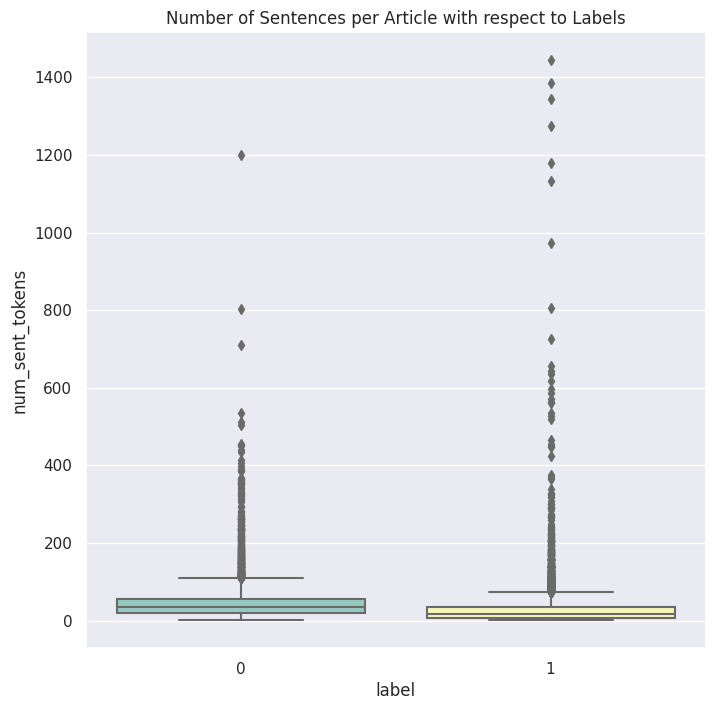

In [ ]:
## Find number of sentences using sentence tokenizer
#-------------------------------------------------------------------------------
org_train_df['sent_tokens'] = org_train_df['text'].apply(sent_tokenize)
org_train_df['num_sent_tokens'] = org_train_df['sent_tokens'].apply(len)


## Boxplot
#-------------------------------------------------------------------------------
sns.boxplot(y= 'num_sent_tokens', x= 'label', data= org_train_df, palette= 'Set3')
plt.title("Number of Sentences per Article with respect to Labels")
plt.show()

**The median fake news have lower number of sentences than that in genuine news. In addition to that, 75% of fake articles have lower number of sentences than 50% of genuine articles.**

**2. Average Words per Sentence in an Article**

Before counting number of words per sentence, I need to clean the punctuations from sent_tkoens. Then, I have to apply word tokenizer. Finally, I'll calculate average words per sentence with respect to each articles.

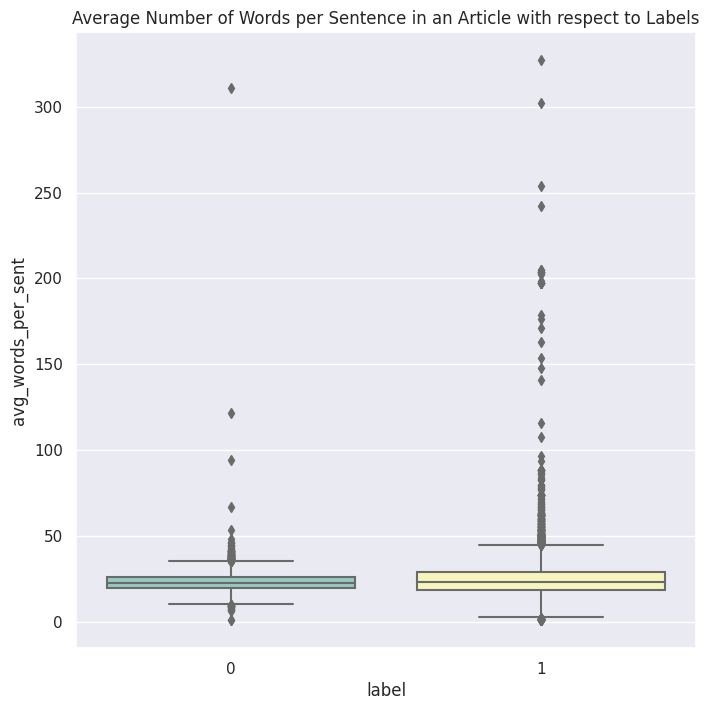

In [ ]:
## Function for removal of punctuations
#-------------------------------------------------------------------------------
remove_punct = lambda x: x.translate(str.maketrans('', '', string.punctuation))


## Function for tokenizing each sentences into words
#-------------------------------------------------------------------------------
def cleaned_word_tokens(seq):
  clean_seq = [remove_punct(sent) for sent in seq]
  word_tokenize_sent = [word_tokenize(sent) for sent in clean_seq]
  return word_tokenize_sent


## Function to calculate avg words per sentence
#-------------------------------------------------------------------------------
def avg_words_per_sentence(seq):
  return np.mean([len(words) for words in seq])


## Apply functions
#-------------------------------------------------------------------------------
org_train_df['word_tokenize_sent'] = org_train_df['sent_tokens'].apply(cleaned_word_tokens)
org_train_df['avg_words_per_sent'] = org_train_df['word_tokenize_sent'].apply(avg_words_per_sentence)


## Boxplot
#-------------------------------------------------------------------------------
sns.boxplot(y= 'avg_words_per_sent', x= 'label', data= org_train_df, palette= 'Set3')
plt.title("Average Number of Words per Sentence in an Article with respect to Labels")
plt.show()

**Even though, there are comparatively many outliers in fake articles, but they are relatively wordier than genuine news.**

**3. Average Length of Words per Article**

This is the average word length in one article OR average number of characters in each word for each article.

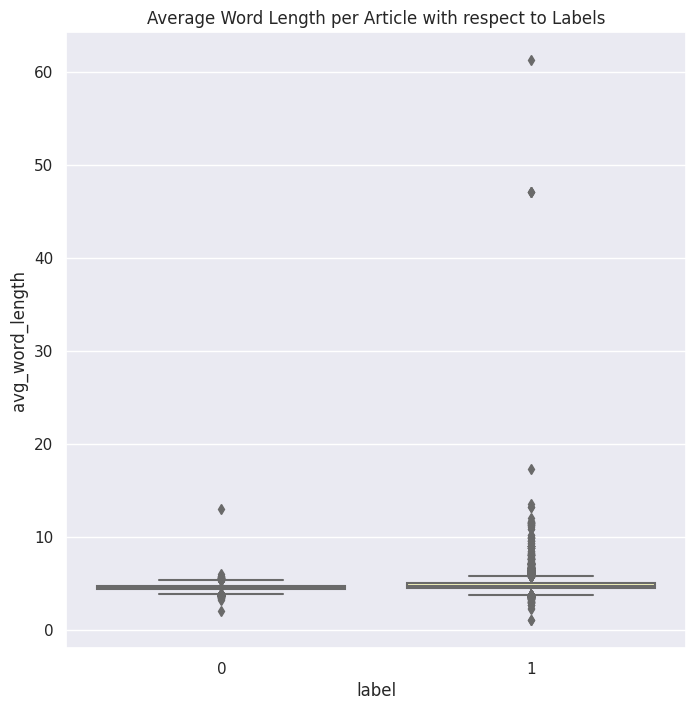

In [ ]:
## Function to get avg word length
#-------------------------------------------------------------------------------
def avg_word_length_per_art(seq):
  return np.mean([len(word) for sent in seq for word in sent])


## Apply function
#-------------------------------------------------------------------------------
org_train_df['avg_word_length'] = org_train_df['word_tokenize_sent'].apply(
    avg_word_length_per_art)


## Boxplot
#-------------------------------------------------------------------------------
sns.boxplot(y= 'avg_word_length', x= 'label', data= org_train_df, palette= 'Set3')
plt.title("Average Word Length per Article with respect to Labels")
plt.show()

**There is no conclusive difference in average word length for both cases, but on average, fake articles have slightly longer words than genuine ones.**

**4. POS Tag Counts**

Looking at the part of speech (POS) combination in genuine articles against fake articles.

In [ ]:
## Function to get the POS tag for each word in a sequence
#-------------------------------------------------------------------------------
def get_pos_tag(seq):
  word_tag_seq = nltk.pos_tag(seq)
  tags_seq = [word_tag[1] for word_tag in word_tag_seq]
  return tags_seq


## Apply function
#-------------------------------------------------------------------------------
gen_tags_series = train_df[train_df['label'] == 0]['text'].apply(get_pos_tag)
fake_tags_series = train_df[train_df['label'] == 1]['text'].apply(get_pos_tag)


## Collect all pos tags with respect to each label
#-------------------------------------------------------------------------------
all_gen_tags = [tag for seq in gen_tags_series for tag in seq]
all_fake_tags = [tag for seq in fake_tags_series for tag in seq]


## Create dataframe of POS tag and its associated frequency wrt each label
#-------------------------------------------------------------------------------
gen_tags_df = pd.DataFrame(dict(Counter(all_gen_tags)).items(), columns= ['POS_tag', 'genuine_news_freq'])
fake_tags_df = pd.DataFrame(dict(Counter(all_fake_tags)).items(), columns= ['POS_tag', 'fake_news_freq'])


## Merge dataframes and convert frequency to percentage
#-------------------------------------------------------------------------------
pos_df = gen_tags_df.merge(fake_tags_df, on= 'POS_tag')
pos_df['genuine_news_freq'] = pos_df['genuine_news_freq']*100/pos_df['genuine_news_freq'].sum()
pos_df['fake_news_freq'] = pos_df['fake_news_freq']*100/pos_df['fake_news_freq'].sum()

In [ ]:
## Looking at POS dataframe

pos_df.head()

,POS_tag,genuine_news_freq,fake_news_freq
0,RB,5.094240,5.524326
1,VB,1.825582,2.001113
2,JJ,17.909354,18.972012
3,NN,33.871054,33.649172
4,NNS,13.260520,12.402681


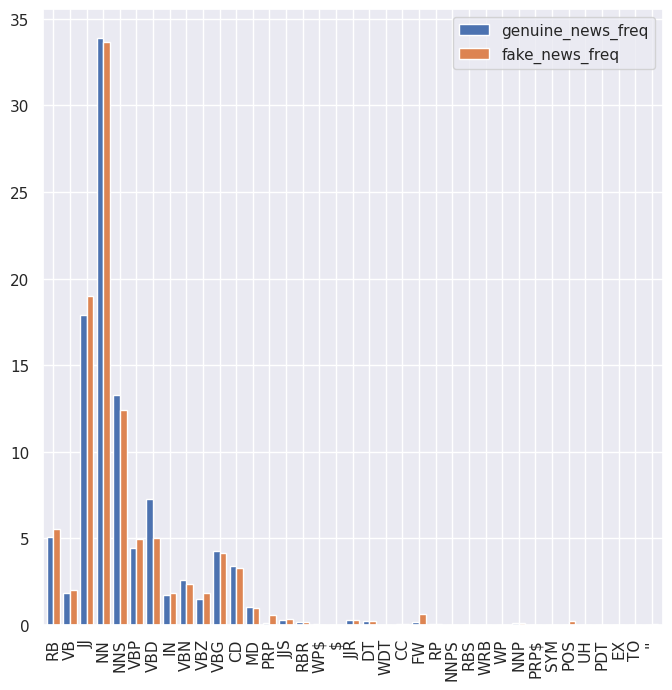

In [ ]:
## Plot POS tags vs frequency as per labels

pos_df.plot.bar(width= 0.8)
plt.xticks(range(len(pos_df['POS_tag'])), pos_df['POS_tag'])
plt.show()

**There is no distinct pattern observed except for percentage of past-tense verbs in genuine articles, which is approximately double of that in fake ones.  Apart from that, all other POS types are almost equal in fake and genuine articles.**